# ConvNeXt-SwinTransformer


Found 9920 validated image filenames belonging to 6 classes.
Found 2480 validated image filenames belonging to 6 classes.

Epoch 1/20


C:\ProgramData\Anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Batch 1/310 ━━━━━━━━━━━━━━━━━━━━ 17:20:04
Accuracy: 0.0000 - Loss: 2.6901

Batch 2/310 ━━━━━━━━━━━━━━━━━━━━ 17:20:56
Accuracy: 0.1250 - Loss: 2.2372

Batch 3/310 ━━━━━━━━━━━━━━━━━━━━ 17:22:06
Accuracy: 0.1875 - Loss: 2.1685

Batch 4/310 ━━━━━━━━━━━━━━━━━━━━ 17:22:56
Accuracy: 0.2266 - Loss: 2.0710

Batch 5/310 ━━━━━━━━━━━━━━━━━━━━ 17:23:45
Accuracy: 0.2688 - Loss: 1.9543

Batch 6/310 ━━━━━━━━━━━━━━━━━━━━ 17:24:34
Accuracy: 0.3073 - Loss: 1.8663

Batch 7/310 ━━━━━━━━━━━━━━━━━━━━ 17:25:23
Accuracy: 0.3438 - Loss: 1.7981

Batch 8/310 ━━━━━━━━━━━━━━━━━━━━ 17:26:11
Accuracy: 0.3438 - Loss: 1.8018

Batch 9/310 ━━━━━━━━━━━━━━━━━━━━ 17:27:00
Accuracy: 0.3715 - Loss: 1.7681

Batch 10/310 ━━━━━━━━━━━━━━━━━━━━ 17:27:48
Accuracy: 0.3812 - Loss: 1.7179

Batch 11/310 ━━━━━━━━━━━━━━━━━━━━ 17:28:37
Accuracy: 0.4006 - Loss: 1.6665

Batch 12/310 ━━━━━━━━━━━━━━━━━━━━ 17:29:26
Accuracy: 0.3984 - Loss: 1.6677

Batch 13/310 ━━━━━━━━━━━━━━━━━━━━ 17:30:14
Accuracy: 0.3942 - Loss: 1.6680

Batch 14/310 ━━━━━━━━

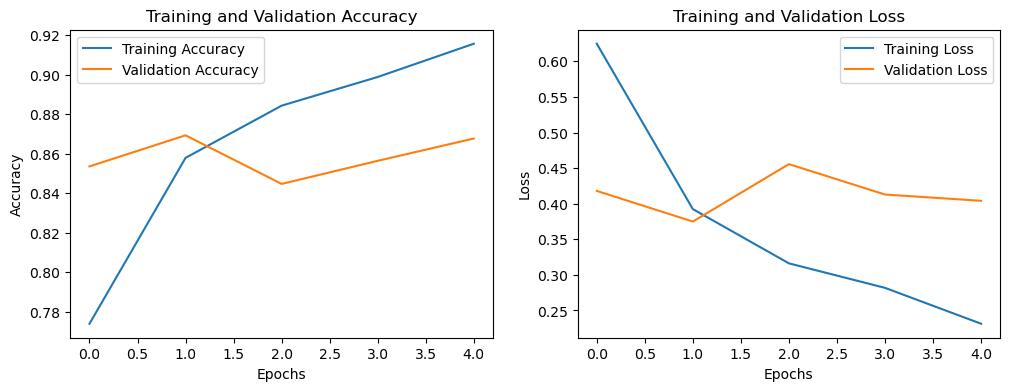

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, LayerNormalization, Flatten, Dropout, Conv2D, Reshape, MultiHeadAttention, Add
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ConvNeXtBase
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from datetime import datetime

# Parameters
num_classes = 6
image_size = (224, 224)
patch_size = 4
num_heads = 4
dropout_rate = 0.1
batch_size = 32
epochs = 20

# Custom Swin Transformer Block
def swin_transformer_block(inputs, embed_dim, num_heads, window_size=7):
    # Layer Normalization and Windowed Multi-Head Attention
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(x, x)
    
    # Skip connection
    x = Add()([x, inputs])
    return x

# ConvNeXt + Swin Transformer Model
def create_convnext_swin_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # ConvNeXt Backbone
    convnext = ConvNeXtBase(include_top=False, weights="imagenet", input_tensor=inputs)
    convnext.trainable = False
    x = convnext(inputs)
    
    # Swin Transformer Layer
    x = swin_transformer_block(x, embed_dim=x.shape[-1], num_heads=num_heads)
    
    x = LayerNormalization(epsilon=1e-6)(x)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(num_classes, activation="softmax")(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Simplified Metrics Callback
class MetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, total_batches):
        super().__init__()
        self.total_batches = total_batches

    def on_epoch_begin(self, epoch, logs=None):
        print(f"\nEpoch {epoch + 1}/{self.params['epochs']}")

    def on_batch_end(self, batch, logs=None):
        logs = logs or {}
        accuracy = logs.get('accuracy', 0)
        loss = logs.get('loss', 0)
        current_time = datetime.now().strftime("%H:%M:%S")
        print(f"Batch {batch+1}/{self.total_batches} ━━━━━━━━━━━━━━━━━━━━ {current_time}")
        print(f"Accuracy: {accuracy:.4f} - Loss: {loss:.4f}\n")

# Compile Model
input_shape = (224, 224, 3)
model = create_convnext_swin_model(input_shape, num_classes)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

# Data Loading and Preprocessing
csv_path = r"C:\Users\Jaber\OneDrive - University of Florida\Educational\GitHub\Ultrasound_Fetal\Data\FETAL_PLANES_DB_data.csv"
df = pd.read_csv(csv_path, delimiter=";")

# Shuffle the DataFrame for a random split
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Add .png extension to each image name
df["Image_name"] = df["Image_name"].apply(lambda x: f"{x}.png")

# Image data generator with train-validation split
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_gen = datagen.flow_from_dataframe(
    dataframe=df,
    directory=r"C:\Users\Jaber\OneDrive - University of Florida\Educational\GitHub\Ultrasound_Fetal\Data\Images",
    x_col="Image_name",
    y_col="Plane",
    target_size=image_size,
    class_mode="sparse",
    batch_size=batch_size,
    subset="training"
)

val_gen = datagen.flow_from_dataframe(
    dataframe=df,
    directory=r"C:\Users\Jaber\OneDrive - University of Florida\Educational\GitHub\Ultrasound_Fetal\Data\Images",
    x_col="Image_name",
    y_col="Plane",
    target_size=image_size,
    class_mode="sparse",
    batch_size=batch_size,
    subset="validation",
    shuffle=False
)

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Training with Metrics Callback
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs,
    callbacks=[early_stopping, MetricsCallback(total_batches=len(train_gen))],
    verbose=0  # Set verbose to 0 to avoid duplicate output
)

# Evaluate on Validation Data
val_loss, val_accuracy = model.evaluate(val_gen)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

# Calculate Metrics on Validation Set
val_preds = model.predict(val_gen)
val_labels = val_gen.classes

# Convert predictions to label format
val_preds = np.argmax(val_preds, axis=1)

precision = precision_score(val_labels, val_preds, average='weighted')
recall = recall_score(val_labels, val_preds, average='weighted')
f1 = f1_score(val_labels, val_preds, average='weighted')
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

# Visualization of Training History
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()
